### **Expanded Momentum Model**
策略出處：

本策略源自Trading Evolved Ch12中的Expanded Momentum Model，核心理念在於找尋過去N天股價走勢穩定向上之個股，經由迴歸係數與決定係數($R^2$)給予加權分數，作為股票的主要篩選依據，接著計算該股票近K天的報酬率標準差，進行反向權重配置，意即波動太大之個股給予較小的持股比率，反之則給予較大的持股比率。

* 註：為避免太多運算造成計算過久，本範例以台灣50(0050)成分股為主要股票池

交易邏輯：

* 選股邏輯：

        計算股票過去N天的動能分數，篩選其中最高的M檔股票作為持股標的

* 配置邏輯：

        以股票近K天的報酬率計算標準差，進行反向權重配置

### Tejapi、Zipline、Pyfolio套件引入

In [1]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = 'your key'
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor, AverageDollarVolume, SimpleMovingAverage, Returns
from zipline.master import get_prices, getToolData, tejquant, run_pipeline
from TejToolAPI.TejToolAPI import get_history_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         order_target_percent, 
                         order_target_value,
                         symbol, 
                         set_commission, 
                         set_slippage, 
                         schedule_function, 
                         date_rules, 
                         time_rules, 
                         get_datetime, 
                         commission,
                         slippage,)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet, tejquant
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from scipy import stats  

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

#### 資料載入－Tejapi、TejToolAPI

* 擷取2015/01/01至2023/07/31所有上下市櫃公司股票代碼

In [4]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2015-01-01'
end = '2023-07-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e = ['Common Stock', 'Common Stock-Foreign'])

[2024-01-19 09:29:25.282679]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock', 'Common Stock-Foreign']}


* Ingest上述公司2015-01-01至2023-07-31的股價資料進bundle

In [5]:
os.environ['ticker'] = ' '.join(pool)

os.environ['mdate'] = '20150101 20230731'

!zipline ingest -b tquant

Merging daily equity files:


[2024-01-19 09:29:36.714362] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-01-19 09:35:05.293859] INFO: zipline.data.bundles.core: Ingest tquant successfully.


* 使用get_history_data載入上述公司同期間之台灣50成分股標記

In [6]:
fg0050 = get_history_data(ticker=pool, columns=['Component_Stock_of_TWN50_Fg'], start='2015-01-01', end='2023-07-31')

In [7]:
fg0050['Component_Stock_of_TWN50_Fg'] = fg0050['Component_Stock_of_TWN50_Fg'].replace({'Y': 1, '': 0})

fg0050 = fg0050.sort_values(['coid', 'mdate'])

* 將載入後的資料轉換成Zipline所需格式

In [8]:
def Custom_loader(df, bundle):

    df['coid'] = df['coid'].astype(str)
    
    column = df.columns[~df.columns.isin(['coid', 'mdate'])].tolist()

    sids = bundle.asset_finder.equities_sids
    assets = bundle.asset_finder.retrieve_all(sids)
    symbols = [i.symbol for i in assets] 

    target_symbols = df[df['coid'].isin(symbols)]['coid'].unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(target_symbols, as_of_date=None)
    assets_map = {i.symbol: i for i in assets}

    baseline_data = {}

    df1 = df.set_index(['coid', 'mdate'])
    for i in column:
        target = df1.unstack('coid')[i][target_symbols]
        target.columns = target.columns.map(assets_map)
        target = target.tz_localize('UTC').tz_convert('UTC')
        baseline_data.update({i: target})

    return baseline_data

In [9]:
bundle = bundles.load('tquant')

baseline_data = Custom_loader(fg0050, bundle)

In [10]:
baseline_data['Component_Stock_of_TWN50_Fg']

coid,Equity(0 [1101]),Equity(1 [1102]),Equity(2 [1103]),Equity(3 [1104]),Equity(4 [1108]),Equity(5 [1109]),Equity(6 [1110]),Equity(7 [1201]),Equity(8 [1203]),Equity(9 [1210]),...,Equity(1903 [9944]),Equity(1904 [9945]),Equity(1905 [9946]),Equity(1906 [9949]),Equity(1907 [9950]),Equity(1908 [9951]),Equity(1909 [9955]),Equity(1910 [9958]),Equity(1911 [9960]),Equity(1912 [9962])
mdate,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-08 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09 00:00:00+00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-07-26 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-07-27 00:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
class CustomDataset(DataSet):
    fg = Column(dtype=float)

    domain = TW_EQUITIES     
    
transform_data = {CustomDataset.fg: DataFrameLoader(CustomDataset.fg, baseline_data['Component_Stock_of_TWN50_Fg'])}

transform_data

{CustomDataset<TW>.fg::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x207b0fb6430>}

### Pipeline－動能因子計算

* 動能分數與波動度計算

In [12]:
def momentum_score(ts):

    x = np.arange(len(ts)) 

    log_ts = np.log(ts) 

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)

    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100

    score = annualized_slope * (r_value ** 2)
    
    return score

* 設定為0050成分股才可以計算動能分數

In [13]:
class factor_momentum_score(CustomFactor):

    inputs = [TWEquityPricing.close, CustomDataset.fg]

    def compute(self, today, assets, out, close, fg):

        close, fg = pd.DataFrame(close), pd.DataFrame(fg)

        target_stock = fg.iloc[-1][fg.iloc[-1].eq(1)].index
        
        out[:] = [momentum_score(close[i]) if i in target_stock else np.nan for i in close]

* 計算週期：近20天收盤價

* 篩選標準：
  * 篩選出動能分數大於0
  * 動能分數大於全體動能分數中位數的個股

In [14]:
def make_pipeline():

    mom_signals = factor_momentum_score(window_length=20)

    close = TWEquityPricing.close.latest

    pipe = Pipeline(
        columns={
            'mom_score': mom_signals,
            
            'close':close,
        },
        screen=(mom_signals > 0) & (mom_signals > mom_signals.median())
    )
    return pipe

In [15]:
start_dt = pd.Timestamp('2015-01-01', tz='utc')
end_dt = pd.Timestamp('2023-07-31', tz='utc')

from zipline.data import bundles

bundle = bundles.load('tquant')

from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)

def choose_loader(column):
    if column in TWEquityPricing.columns:
        return pricing_loader
    return transform_data[column]

from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(get_loader=choose_loader,
                              asset_finder=bundle.asset_finder,
                              )

pipe = make_pipeline()
data = engine.run_pipeline(pipe, start_dt, end_dt)
data.dropna(axis=0)

mom_score   close
2015-02-02 00:00:00+00:00 Equity(12 [1216])     104.782181   50.50
                          Equity(33 [1301])     232.346669   76.50
                          Equity(34 [1303])      38.095884   63.50
                          Equity(51 [1326])     205.992225   67.80
                          Equity(60 [1402])      49.745482   31.80
...                                                    ...     ...
2023-07-31 00:00:00+00:00 Equity(627 [3037])   1120.226598  191.00
                          Equity(923 [3711])     35.451410  117.50
                          Equity(1113 [4938])   274.023578   78.70
                          Equity(1305 [5880])    37.012132   29.25
                          Equity(1877 [9910])   167.402697  212.00

[42846 rows x 2 columns]

### Zipline－策略回測
  
* 設定固定滑價成本和交易手續費各為0.2%
  
* 月初進場邏輯：每天買進股票池中符合條件之個股，使用反向波動度進行加權配置
  
* 月底出場邏輯：若投組內個股在月底並不在待交易清單內則出清

In [16]:
def initialize1(context):

    set_slippage(slippage.FixedSlippage(spread=0.002))
    set_commission(commission.PerDollar(cost=0.002))
    

    schedule_function(
        func=rebalance_start,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

    schedule_function(
        func=rebalance_end,
        date_rule=date_rules.month_end(),
        time_rule=time_rules.market_open()
    )
    
    pipeline = make_pipeline()
    attach_pipeline(pipeline, 'make_pipeline')

def before_trading_start(context, data):

    context.trades = pipeline_output('make_pipeline')
    
def rebalance_start(context, data):

    if len(context.trades) != 0:

        target = context.trades
        
        for stock in target.index:

            if data.can_trade(stock):
                
                hist_vol = data.history(stock, "close", 120, "1d").pct_change().rolling(20).std().iloc[-1]

                target.loc[stock, 'pos'] = 1 / hist_vol

        for stock, pos in zip(target.index, target.pos):

            if stock not in context.portfolio.positions.keys():

                order_value = (pos / target.pos.sum()) * context.portfolio.cash

                order_target_value(stock, order_value)

def rebalance_end(context, data):

    if len(context.trades) != 0:

        target = context.trades
                
        for stock in list(context.portfolio.positions.keys()):

            if stock not in target.index:

                order_target_value(stock, 0)


def portfolio_plot(context, results):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod()*1000000

    results[['portfolio_value', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')

    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc='upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.show()

[2024-01-19 09:35:50.514004]: INFO: transform: 2
[2024-01-19 09:35:50.515001]: INFO: transform: 4
[2024-01-19 09:35:50.980968]: INFO: transform: 1
[2024-01-19 09:35:50.984965]: INFO: transform: 3
[2024-01-19 09:35:50.985968]: INFO: transform: 2
[2024-01-19 09:35:50.986964]: INFO: transform: 4
[2024-01-19 09:35:50.987964]: INFO: transform: 1
[2024-01-19 09:35:50.988969]: INFO: transform: 3
[2024-01-19 09:35:50.989965]: INFO: transform: 2
[2024-01-19 09:35:50.989965]: INFO: transform: 4
[2024-01-19 09:35:50.991965]: INFO: transform: 1
[2024-01-19 09:35:50.991965]: INFO: transform: 3
[2024-01-19 09:35:50.992965]: INFO: transform: 2
[2024-01-19 09:35:50.993970]: INFO: transform: 4
[2024-01-19 09:35:50.994964]: INFO: transform: 1
[2024-01-19 09:35:50.995964]: INFO: transform: 3
[2024-01-19 09:35:50.996965]: INFO: transform: 2
[2024-01-19 09:35:50.996965]: INFO: transform: 4
[2024-01-19 09:35:50.998970]: INFO: transform: 1
[2024-01-19 09:35:50.998970]: INFO: transform: 3
[2024-01-19 09:35:50

[2024-01-19 09:35:52.849827]: INFO: transform: 2
[2024-01-19 09:35:52.850827]: INFO: transform: 4
[2024-01-19 09:35:52.851826]: INFO: transform: 1
[2024-01-19 09:35:52.851826]: INFO: transform: 3
[2024-01-19 09:35:52.859826]: INFO: transform: 2
[2024-01-19 09:35:52.860826]: INFO: transform: 4
[2024-01-19 09:35:52.861826]: INFO: transform: 1
[2024-01-19 09:35:52.861826]: INFO: transform: 3
[2024-01-19 09:35:52.868825]: INFO: transform: 2
[2024-01-19 09:35:52.869825]: INFO: transform: 4
[2024-01-19 09:35:52.870825]: INFO: transform: 1
[2024-01-19 09:35:52.871823]: INFO: transform: 3
[2024-01-19 09:35:52.878824]: INFO: transform: 2
[2024-01-19 09:35:52.879822]: INFO: transform: 4
[2024-01-19 09:35:52.880826]: INFO: transform: 1
[2024-01-19 09:35:52.880826]: INFO: transform: 3
[2024-01-19 09:35:52.887824]: INFO: transform: 2
[2024-01-19 09:35:52.888824]: INFO: transform: 4
[2024-01-19 09:35:52.889821]: INFO: transform: 1
[2024-01-19 09:35:52.890821]: INFO: transform: 3
[2024-01-19 09:35:52

[2024-01-19 09:35:53.429835]: INFO: transform: 2
[2024-01-19 09:35:53.430835]: INFO: transform: 4
[2024-01-19 09:35:53.431833]: INFO: transform: 1
[2024-01-19 09:35:53.432832]: INFO: transform: 3
[2024-01-19 09:35:53.439834]: INFO: transform: 2
[2024-01-19 09:35:53.440834]: INFO: transform: 4
[2024-01-19 09:35:53.441831]: INFO: transform: 1
[2024-01-19 09:35:53.441831]: INFO: transform: 3
[2024-01-19 09:35:53.449834]: INFO: transform: 2
[2024-01-19 09:35:53.450834]: INFO: transform: 4
[2024-01-19 09:35:53.451834]: INFO: transform: 1
[2024-01-19 09:35:53.451834]: INFO: transform: 3
[2024-01-19 09:35:53.459833]: INFO: transform: 2
[2024-01-19 09:35:53.460833]: INFO: transform: 4
[2024-01-19 09:35:53.460833]: INFO: transform: 1
[2024-01-19 09:35:53.461833]: INFO: transform: 3
[2024-01-19 09:35:53.468832]: INFO: transform: 2
[2024-01-19 09:35:53.469832]: INFO: transform: 4
[2024-01-19 09:35:53.470829]: INFO: transform: 1
[2024-01-19 09:35:53.470829]: INFO: transform: 3
[2024-01-19 09:35:53

[2024-01-19 09:35:53.938853]: INFO: transform: 1
[2024-01-19 09:35:53.938853]: INFO: transform: 3
[2024-01-19 09:35:53.945855]: INFO: transform: 2
[2024-01-19 09:35:53.946852]: INFO: earn_dividends: Equity(417 [2454]), cash_dividend amount: 21.99993374, pay_date: 2015-08-07, div_owed: 2243.99324148
[2024-01-19 09:35:53.946852]: INFO: earn_dividends: Equity(1094 [4904]), cash_dividend amount: 3.75, pay_date: 2015-08-07, div_owed: 1485.0
[2024-01-19 09:35:53.947854]: INFO: transform: 4
[2024-01-19 09:35:53.948853]: INFO: transform: 1
[2024-01-19 09:35:53.948853]: INFO: transform: 3
[2024-01-19 09:35:53.955855]: INFO: transform: 2
[2024-01-19 09:35:53.956855]: INFO: earn_dividends: Equity(383 [2412]), cash_dividend amount: 4.8564, pay_date: 2015-08-27, div_owed: 2981.8296
[2024-01-19 09:35:53.957852]: INFO: transform: 4
[2024-01-19 09:35:53.958853]: INFO: transform: 1
[2024-01-19 09:35:53.958853]: INFO: transform: 3
[2024-01-19 09:35:53.966855]: INFO: transform: 2
[2024-01-19 09:35:53.967

[2024-01-19 09:35:55.725721]: INFO: transform: 2
[2024-01-19 09:35:55.726718]: INFO: transform: 4
[2024-01-19 09:35:55.727717]: INFO: transform: 1
[2024-01-19 09:35:55.736720]: INFO: transform: 3
[2024-01-19 09:35:55.741720]: INFO: transform: 2
[2024-01-19 09:35:55.742717]: INFO: transform: 4
[2024-01-19 09:35:55.743717]: INFO: transform: 1
[2024-01-19 09:35:55.767718]: INFO: transform: 3
[2024-01-19 09:35:55.769718]: INFO: transform: 2
[2024-01-19 09:35:55.770716]: INFO: transform: 4
[2024-01-19 09:35:55.771714]: INFO: transform: 1
[2024-01-19 09:35:55.775717]: INFO: transform: 3
[2024-01-19 09:35:55.778717]: INFO: transform: 2
[2024-01-19 09:35:55.779714]: INFO: transform: 4
[2024-01-19 09:35:55.780714]: INFO: transform: 1
[2024-01-19 09:35:55.780714]: INFO: transform: 3
[2024-01-19 09:35:55.783717]: INFO: transform: 2
[2024-01-19 09:35:55.784713]: INFO: transform: 4
[2024-01-19 09:35:55.785713]: INFO: transform: 1
[2024-01-19 09:35:55.785713]: INFO: transform: 3
[2024-01-19 09:35:55

[2024-01-19 09:35:56.160689]: INFO: transform: 2
[2024-01-19 09:35:56.161689]: INFO: transform: 4
[2024-01-19 09:35:56.161689]: INFO: transform: 1
[2024-01-19 09:35:56.218684]: INFO: transform: 3
[2024-01-19 09:35:56.222685]: INFO: transform: 2
[2024-01-19 09:35:56.223684]: INFO: transform: 4
[2024-01-19 09:35:56.223684]: INFO: transform: 1
[2024-01-19 09:35:56.231683]: INFO: transform: 3
[2024-01-19 09:35:56.237682]: INFO: transform: 2
[2024-01-19 09:35:56.239683]: INFO: transform: 4
[2024-01-19 09:35:56.239683]: INFO: transform: 1
[2024-01-19 09:35:56.240679]: INFO: transform: 3
[2024-01-19 09:35:56.246679]: INFO: transform: 2
[2024-01-19 09:35:56.247678]: INFO: transform: 4
[2024-01-19 09:35:56.248678]: INFO: transform: 1
[2024-01-19 09:35:56.248678]: INFO: transform: 3
[2024-01-19 09:35:56.255681]: INFO: transform: 2
[2024-01-19 09:35:56.256682]: INFO: transform: 4
[2024-01-19 09:35:56.257060]: INFO: transform: 1
[2024-01-19 09:35:56.258143]: INFO: transform: 3
[2024-01-19 09:35:56

[2024-01-19 09:35:56.533045]: INFO: transform: 3
[2024-01-19 09:35:56.535045]: INFO: transform: 2
[2024-01-19 09:35:56.536045]: INFO: transform: 4
[2024-01-19 09:35:56.537045]: INFO: transform: 1
[2024-01-19 09:35:56.537045]: INFO: transform: 3
[2024-01-19 09:35:56.540045]: INFO: transform: 2
[2024-01-19 09:35:56.541045]: INFO: transform: 4
[2024-01-19 09:35:56.541045]: INFO: transform: 1
[2024-01-19 09:35:56.542045]: INFO: transform: 3
[2024-01-19 09:35:56.544045]: INFO: transform: 2
[2024-01-19 09:35:56.545044]: INFO: transform: 4
[2024-01-19 09:35:56.546044]: INFO: transform: 1
[2024-01-19 09:35:56.549044]: INFO: transform: 3
[2024-01-19 09:35:56.551044]: INFO: transform: 2
[2024-01-19 09:35:56.552044]: INFO: transform: 4
[2024-01-19 09:35:56.552044]: INFO: transform: 1
[2024-01-19 09:35:56.623038]: INFO: transform: 3
[2024-01-19 09:35:56.625038]: INFO: transform: 2
[2024-01-19 09:35:56.626038]: INFO: transform: 4
[2024-01-19 09:35:56.627038]: INFO: transform: 1
[2024-01-19 09:35:56

[2024-01-19 09:35:58.745359]: INFO: transform: 1
[2024-01-19 09:35:58.746358]: INFO: transform: 3
[2024-01-19 09:35:58.754360]: INFO: transform: 2
[2024-01-19 09:35:58.755358]: INFO: transform: 4
[2024-01-19 09:35:58.756357]: INFO: transform: 1
[2024-01-19 09:35:58.756357]: INFO: transform: 3
[2024-01-19 09:35:58.764357]: INFO: transform: 2
[2024-01-19 09:35:58.765357]: INFO: transform: 4
[2024-01-19 09:35:58.766357]: INFO: transform: 1
[2024-01-19 09:35:58.766357]: INFO: transform: 3
[2024-01-19 09:35:58.775357]: INFO: transform: 2
[2024-01-19 09:35:58.776357]: INFO: transform: 4
[2024-01-19 09:35:58.776357]: INFO: transform: 1
[2024-01-19 09:35:58.777355]: INFO: transform: 3
[2024-01-19 09:35:58.785356]: INFO: transform: 2
[2024-01-19 09:35:58.786356]: INFO: transform: 4
[2024-01-19 09:35:58.787355]: INFO: transform: 1
[2024-01-19 09:35:58.787355]: INFO: transform: 3
[2024-01-19 09:35:58.795355]: INFO: transform: 2
[2024-01-19 09:35:58.796355]: INFO: transform: 4
[2024-01-19 09:35:58

[2024-01-19 09:35:59.353562]: INFO: transform: 1
[2024-01-19 09:35:59.353562]: INFO: transform: 3
[2024-01-19 09:35:59.361559]: INFO: transform: 2
[2024-01-19 09:35:59.362559]: INFO: transform: 4
[2024-01-19 09:35:59.363555]: INFO: transform: 1
[2024-01-19 09:35:59.363555]: INFO: transform: 3
[2024-01-19 09:35:59.371558]: INFO: transform: 2
[2024-01-19 09:35:59.372558]: INFO: transform: 4
[2024-01-19 09:35:59.373560]: INFO: transform: 1
[2024-01-19 09:35:59.373560]: INFO: transform: 3
[2024-01-19 09:35:59.381557]: INFO: transform: 2
[2024-01-19 09:35:59.382557]: INFO: transform: 4
[2024-01-19 09:35:59.383559]: INFO: transform: 1
[2024-01-19 09:35:59.383559]: INFO: transform: 3
[2024-01-19 09:35:59.391556]: INFO: transform: 2
[2024-01-19 09:35:59.392556]: INFO: transform: 4
[2024-01-19 09:35:59.393557]: INFO: transform: 1
[2024-01-19 09:35:59.393557]: INFO: transform: 3
[2024-01-19 09:35:59.401555]: INFO: transform: 2
[2024-01-19 09:35:59.402552]: INFO: transform: 4
[2024-01-19 09:35:59

[2024-01-19 09:35:59.817173]: INFO: transform: 3
[2024-01-19 09:35:59.823169]: INFO: transform: 2
[2024-01-19 09:35:59.825173]: INFO: transform: 4
[2024-01-19 09:35:59.826169]: INFO: transform: 1
[2024-01-19 09:35:59.892167]: INFO: transform: 3
[2024-01-19 09:35:59.896164]: INFO: transform: 2
[2024-01-19 09:35:59.897164]: INFO: transform: 4
[2024-01-19 09:35:59.898163]: INFO: transform: 1
[2024-01-19 09:35:59.909163]: INFO: transform: 3
[2024-01-19 09:35:59.917165]: INFO: transform: 2
[2024-01-19 09:35:59.918163]: INFO: transform: 4
[2024-01-19 09:35:59.919162]: INFO: transform: 1
[2024-01-19 09:35:59.919162]: INFO: transform: 3
[2024-01-19 09:35:59.927164]: INFO: transform: 2
[2024-01-19 09:35:59.928162]: INFO: transform: 4
[2024-01-19 09:35:59.929161]: INFO: transform: 1
[2024-01-19 09:35:59.929161]: INFO: transform: 3
[2024-01-19 09:35:59.937163]: INFO: transform: 2
[2024-01-19 09:35:59.937163]: INFO: earn_dividends: Equity(313 [2308]), cash_dividend amount: 5.0, pay_date: 2016-07-2

[2024-01-19 09:36:01.746027]: INFO: transform: 2
[2024-01-19 09:36:01.747024]: INFO: transform: 4
[2024-01-19 09:36:01.747621]: INFO: transform: 1
[2024-01-19 09:36:01.748627]: INFO: transform: 3
[2024-01-19 09:36:01.756629]: INFO: transform: 2
[2024-01-19 09:36:01.757630]: INFO: earn_dividends: Equity(314 [2311]), cash_dividend amount: 1.59718596, pay_date: 2016-09-09, div_owed: 1066.92022128
[2024-01-19 09:36:01.758628]: INFO: transform: 4
[2024-01-19 09:36:01.758628]: INFO: transform: 1
[2024-01-19 09:36:01.759627]: INFO: transform: 3
[2024-01-19 09:36:01.767629]: INFO: transform: 2
[2024-01-19 09:36:01.769629]: INFO: transform: 4
[2024-01-19 09:36:01.770625]: INFO: transform: 1
[2024-01-19 09:36:01.770625]: INFO: transform: 3
[2024-01-19 09:36:01.779628]: INFO: transform: 2
[2024-01-19 09:36:01.780628]: INFO: transform: 4
[2024-01-19 09:36:01.780628]: INFO: transform: 1
[2024-01-19 09:36:01.781628]: INFO: transform: 3
[2024-01-19 09:36:01.789627]: INFO: transform: 2
[2024-01-19 09:

[2024-01-19 09:36:02.317584]: INFO: transform: 3
[2024-01-19 09:36:02.325587]: INFO: transform: 2
[2024-01-19 09:36:02.326587]: INFO: transform: 4
[2024-01-19 09:36:02.327583]: INFO: transform: 1
[2024-01-19 09:36:02.327583]: INFO: transform: 3
[2024-01-19 09:36:02.335586]: INFO: transform: 2
[2024-01-19 09:36:02.336583]: INFO: transform: 4
[2024-01-19 09:36:02.336583]: INFO: transform: 1
[2024-01-19 09:36:02.337587]: INFO: transform: 3
[2024-01-19 09:36:02.344585]: INFO: transform: 2
[2024-01-19 09:36:02.345585]: INFO: transform: 4
[2024-01-19 09:36:02.346582]: INFO: transform: 1
[2024-01-19 09:36:02.346582]: INFO: transform: 3
[2024-01-19 09:36:02.354584]: INFO: transform: 2
[2024-01-19 09:36:02.355584]: INFO: transform: 4
[2024-01-19 09:36:02.356585]: INFO: transform: 1
[2024-01-19 09:36:02.356585]: INFO: transform: 3
[2024-01-19 09:36:02.363583]: INFO: transform: 2
[2024-01-19 09:36:02.365584]: INFO: transform: 4
[2024-01-19 09:36:02.365584]: INFO: transform: 1
[2024-01-19 09:36:02

[2024-01-19 09:36:02.893602]: INFO: transform: 3
[2024-01-19 09:36:02.900605]: INFO: transform: 2
[2024-01-19 09:36:02.901601]: INFO: transform: 4
[2024-01-19 09:36:02.902601]: INFO: transform: 1
[2024-01-19 09:36:02.902601]: INFO: transform: 3
[2024-01-19 09:36:02.909604]: INFO: transform: 2
[2024-01-19 09:36:02.910601]: INFO: transform: 4
[2024-01-19 09:36:02.911600]: INFO: transform: 1
[2024-01-19 09:36:02.911600]: INFO: transform: 3
[2024-01-19 09:36:02.918603]: INFO: transform: 2
[2024-01-19 09:36:02.919600]: INFO: transform: 4
[2024-01-19 09:36:02.920600]: INFO: transform: 1
[2024-01-19 09:36:02.920600]: INFO: transform: 3
[2024-01-19 09:36:02.927602]: INFO: transform: 2
[2024-01-19 09:36:02.928599]: INFO: transform: 4
[2024-01-19 09:36:02.929599]: INFO: transform: 1
[2024-01-19 09:36:02.929599]: INFO: transform: 3
[2024-01-19 09:36:02.936602]: INFO: transform: 2
[2024-01-19 09:36:02.937599]: INFO: transform: 4
[2024-01-19 09:36:02.938598]: INFO: transform: 1
[2024-01-19 09:36:02

[2024-01-19 09:36:03.406565]: INFO: transform: 1
[2024-01-19 09:36:03.406565]: INFO: transform: 3
[2024-01-19 09:36:03.415565]: INFO: transform: 2
[2024-01-19 09:36:03.416563]: INFO: transform: 4
[2024-01-19 09:36:03.417562]: INFO: transform: 1
[2024-01-19 09:36:03.417562]: INFO: transform: 3
[2024-01-19 09:36:03.425565]: INFO: transform: 2
[2024-01-19 09:36:03.426562]: INFO: transform: 4
[2024-01-19 09:36:03.427562]: INFO: transform: 1
[2024-01-19 09:36:03.427562]: INFO: transform: 3
[2024-01-19 09:36:03.435564]: INFO: transform: 2
[2024-01-19 09:36:03.437565]: INFO: transform: 4
[2024-01-19 09:36:03.437565]: INFO: transform: 1
[2024-01-19 09:36:03.438561]: INFO: transform: 3
[2024-01-19 09:36:03.446563]: INFO: transform: 2
[2024-01-19 09:36:03.447564]: INFO: transform: 4
[2024-01-19 09:36:04.962497]: INFO: transform: 1
[2024-01-19 09:36:04.963497]: INFO: transform: 3
[2024-01-19 09:36:04.972448]: INFO: transform: 2
[2024-01-19 09:36:04.973444]: INFO: transform: 4
[2024-01-19 09:36:04

[2024-01-19 09:36:05.529403]: INFO: transform: 1
[2024-01-19 09:36:05.529403]: INFO: transform: 3
[2024-01-19 09:36:05.538405]: INFO: transform: 2
[2024-01-19 09:36:05.539403]: INFO: transform: 4
[2024-01-19 09:36:05.540402]: INFO: transform: 1
[2024-01-19 09:36:05.540402]: INFO: transform: 3
[2024-01-19 09:36:05.549404]: INFO: transform: 2
[2024-01-19 09:36:05.550402]: INFO: transform: 4
[2024-01-19 09:36:05.551401]: INFO: transform: 1
[2024-01-19 09:36:05.551401]: INFO: transform: 3
[2024-01-19 09:36:05.559403]: INFO: transform: 2
[2024-01-19 09:36:05.561404]: INFO: transform: 4
[2024-01-19 09:36:05.561404]: INFO: transform: 1
[2024-01-19 09:36:05.562400]: INFO: transform: 3
[2024-01-19 09:36:05.570403]: INFO: transform: 2
[2024-01-19 09:36:05.572401]: INFO: transform: 4
[2024-01-19 09:36:05.572401]: INFO: transform: 1
[2024-01-19 09:36:05.573404]: INFO: transform: 3
[2024-01-19 09:36:05.581402]: INFO: transform: 2
[2024-01-19 09:36:05.583399]: INFO: transform: 4
[2024-01-19 09:36:05

[2024-01-19 09:36:06.080241]: INFO: transform: 1
[2024-01-19 09:36:06.080241]: INFO: transform: 3
[2024-01-19 09:36:06.088244]: INFO: transform: 2
[2024-01-19 09:36:06.089244]: INFO: transform: 4
[2024-01-19 09:36:06.090241]: INFO: transform: 1
[2024-01-19 09:36:06.090241]: INFO: transform: 3
[2024-01-19 09:36:06.098243]: INFO: transform: 2
[2024-01-19 09:36:06.100240]: INFO: transform: 4
[2024-01-19 09:36:06.100240]: INFO: transform: 1
[2024-01-19 09:36:06.101239]: INFO: transform: 3
[2024-01-19 09:36:06.109242]: INFO: transform: 2
[2024-01-19 09:36:06.109242]: INFO: earn_dividends: Equity(381 [2408]), cash_dividend amount: 1.5, pay_date: 2017-07-14, div_owed: 358.5
[2024-01-19 09:36:06.110239]: INFO: transform: 4
[2024-01-19 09:36:06.111242]: INFO: transform: 1
[2024-01-19 09:36:06.112242]: INFO: transform: 3
[2024-01-19 09:36:06.120241]: INFO: transform: 2
[2024-01-19 09:36:06.121242]: INFO: transform: 4
[2024-01-19 09:36:06.122242]: INFO: transform: 1
[2024-01-19 09:36:06.122242]: 

[2024-01-19 09:36:06.471215]: INFO: transform: 3
[2024-01-19 09:36:06.478211]: INFO: transform: 2
[2024-01-19 09:36:06.480215]: INFO: transform: 4
[2024-01-19 09:36:06.480215]: INFO: transform: 1
[2024-01-19 09:36:06.481211]: INFO: transform: 3
[2024-01-19 09:36:06.489213]: INFO: transform: 2
[2024-01-19 09:36:06.490214]: INFO: transform: 4
[2024-01-19 09:36:06.491213]: INFO: transform: 1
[2024-01-19 09:36:06.491213]: INFO: transform: 3
[2024-01-19 09:36:06.499213]: INFO: transform: 2
[2024-01-19 09:36:06.499213]: INFO: earn_dividends: Equity(365 [2382]), cash_dividend amount: 3.5, pay_date: 2017-08-25, div_owed: 3048.5
[2024-01-19 09:36:06.500213]: INFO: transform: 4
[2024-01-19 09:36:06.501210]: INFO: transform: 1
[2024-01-19 09:36:06.513212]: INFO: transform: 3
[2024-01-19 09:36:06.521211]: INFO: transform: 2
[2024-01-19 09:36:06.521211]: INFO: earn_dividends: Equity(1113 [4938]), cash_dividend amount: 4.92865082, pay_date: 2017-08-30, div_owed: 763.9408771
[2024-01-19 09:36:06.5222

[2024-01-19 09:36:08.463450]: INFO: transform: 1
[2024-01-19 09:36:08.463450]: INFO: transform: 3
[2024-01-19 09:36:08.471453]: INFO: transform: 2
[2024-01-19 09:36:08.472450]: INFO: transform: 4
[2024-01-19 09:36:08.473450]: INFO: transform: 1
[2024-01-19 09:36:08.474450]: INFO: transform: 3
[2024-01-19 09:36:08.481452]: INFO: transform: 2
[2024-01-19 09:36:08.482449]: INFO: transform: 4
[2024-01-19 09:36:08.483449]: INFO: transform: 1
[2024-01-19 09:36:08.484462]: INFO: transform: 3
[2024-01-19 09:36:08.491453]: INFO: transform: 2
[2024-01-19 09:36:08.492449]: INFO: transform: 4
[2024-01-19 09:36:08.493448]: INFO: transform: 1
[2024-01-19 09:36:08.493448]: INFO: transform: 3
[2024-01-19 09:36:08.501451]: INFO: transform: 2
[2024-01-19 09:36:08.502449]: INFO: transform: 4
[2024-01-19 09:36:08.502449]: INFO: transform: 1
[2024-01-19 09:36:08.503447]: INFO: transform: 3
[2024-01-19 09:36:08.510450]: INFO: transform: 2
[2024-01-19 09:36:08.511447]: INFO: transform: 4
[2024-01-19 09:36:08

[2024-01-19 09:36:08.914417]: INFO: transform: 3
[2024-01-19 09:36:08.917417]: INFO: transform: 2
[2024-01-19 09:36:08.918417]: INFO: transform: 4
[2024-01-19 09:36:08.919420]: INFO: transform: 1
[2024-01-19 09:36:08.933416]: INFO: transform: 3
[2024-01-19 09:36:08.939469]: INFO: transform: 2
[2024-01-19 09:36:08.941416]: INFO: transform: 4
[2024-01-19 09:36:08.942415]: INFO: transform: 1
[2024-01-19 09:36:08.942415]: INFO: transform: 3
[2024-01-19 09:36:08.948417]: INFO: transform: 2
[2024-01-19 09:36:08.949413]: INFO: transform: 4
[2024-01-19 09:36:08.950414]: INFO: transform: 1
[2024-01-19 09:36:08.950414]: INFO: transform: 3
[2024-01-19 09:36:08.957416]: INFO: transform: 2
[2024-01-19 09:36:08.958417]: INFO: transform: 4
[2024-01-19 09:36:08.959414]: INFO: transform: 1
[2024-01-19 09:36:08.959414]: INFO: transform: 3
[2024-01-19 09:36:08.966415]: INFO: transform: 2
[2024-01-19 09:36:08.967414]: INFO: transform: 4
[2024-01-19 09:36:08.967414]: INFO: transform: 1
[2024-01-19 09:36:08

[2024-01-19 09:36:09.395452]: INFO: transform: 3
[2024-01-19 09:36:09.402451]: INFO: transform: 2
[2024-01-19 09:36:09.403448]: INFO: transform: 4
[2024-01-19 09:36:09.404448]: INFO: transform: 1
[2024-01-19 09:36:09.472446]: INFO: transform: 3
[2024-01-19 09:36:09.476446]: INFO: transform: 2
[2024-01-19 09:36:09.477739]: INFO: transform: 4
[2024-01-19 09:36:09.478738]: INFO: transform: 1
[2024-01-19 09:36:09.490740]: INFO: transform: 3
[2024-01-19 09:36:09.497739]: INFO: transform: 2
[2024-01-19 09:36:09.498737]: INFO: transform: 4
[2024-01-19 09:36:09.499736]: INFO: transform: 1
[2024-01-19 09:36:09.499736]: INFO: transform: 3
[2024-01-19 09:36:09.507739]: INFO: transform: 2
[2024-01-19 09:36:09.508740]: INFO: transform: 4
[2024-01-19 09:36:09.508740]: INFO: transform: 1
[2024-01-19 09:36:09.509735]: INFO: transform: 3
[2024-01-19 09:36:09.516738]: INFO: transform: 2
[2024-01-19 09:36:09.518739]: INFO: transform: 4
[2024-01-19 09:36:09.518739]: INFO: transform: 1
[2024-01-19 09:36:09

[2024-01-19 09:36:11.501036]: INFO: transform: 3
[2024-01-19 09:36:11.504039]: INFO: transform: 2
[2024-01-19 09:36:11.505040]: INFO: transform: 4
[2024-01-19 09:36:11.506039]: INFO: transform: 1
[2024-01-19 09:36:11.506039]: INFO: transform: 3
[2024-01-19 09:36:11.508039]: INFO: transform: 2
[2024-01-19 09:36:11.509039]: INFO: transform: 4
[2024-01-19 09:36:11.510039]: INFO: transform: 1
[2024-01-19 09:36:11.511038]: INFO: transform: 3
[2024-01-19 09:36:11.513038]: INFO: transform: 2
[2024-01-19 09:36:11.514035]: INFO: transform: 4
[2024-01-19 09:36:11.515039]: INFO: transform: 1
[2024-01-19 09:36:11.515039]: INFO: transform: 3
[2024-01-19 09:36:11.518038]: INFO: transform: 2
[2024-01-19 09:36:11.519038]: INFO: transform: 4
[2024-01-19 09:36:11.519038]: INFO: transform: 1
[2024-01-19 09:36:11.520038]: INFO: transform: 3
[2024-01-19 09:36:11.522040]: INFO: transform: 2
[2024-01-19 09:36:11.523038]: INFO: transform: 4
[2024-01-19 09:36:11.524035]: INFO: transform: 1
[2024-01-19 09:36:11

[2024-01-19 09:36:11.957542]: INFO: transform: 3
[2024-01-19 09:36:11.964545]: INFO: transform: 2
[2024-01-19 09:36:11.965542]: INFO: transform: 4
[2024-01-19 09:36:11.966542]: INFO: transform: 1
[2024-01-19 09:36:11.966542]: INFO: transform: 3
[2024-01-19 09:36:11.973544]: INFO: transform: 2
[2024-01-19 09:36:11.974541]: INFO: transform: 4
[2024-01-19 09:36:11.975378]: INFO: transform: 1
[2024-01-19 09:36:11.976384]: INFO: transform: 3
[2024-01-19 09:36:11.982386]: INFO: transform: 2
[2024-01-19 09:36:11.984387]: INFO: transform: 4
[2024-01-19 09:36:11.984387]: INFO: transform: 1
[2024-01-19 09:36:11.985383]: INFO: transform: 3
[2024-01-19 09:36:11.991386]: INFO: transform: 2
[2024-01-19 09:36:11.992386]: INFO: transform: 4
[2024-01-19 09:36:11.993386]: INFO: transform: 1
[2024-01-19 09:36:11.994382]: INFO: transform: 3
[2024-01-19 09:36:12.001385]: INFO: transform: 2
[2024-01-19 09:36:12.002385]: INFO: transform: 4
[2024-01-19 09:36:12.002385]: INFO: transform: 1
[2024-01-19 09:36:12

[2024-01-19 09:36:12.458348]: INFO: transform: 1
[2024-01-19 09:36:12.459348]: INFO: transform: 3
[2024-01-19 09:36:12.463350]: INFO: transform: 2
[2024-01-19 09:36:12.464347]: INFO: earn_dividends: Equity(311 [2303]), cash_dividend amount: 0.7116430699999999, pay_date: 2018-07-31, div_owed: 996.3002979999999
[2024-01-19 09:36:12.464347]: INFO: earn_dividends: Equity(634 [3045]), cash_dividend amount: 5.6, pay_date: 2018-08-01, div_owed: 12118.4
[2024-01-19 09:36:12.465347]: INFO: transform: 4
[2024-01-19 09:36:12.465347]: INFO: transform: 1
[2024-01-19 09:36:12.466347]: INFO: transform: 3
[2024-01-19 09:36:12.470349]: INFO: transform: 2
[2024-01-19 09:36:12.471346]: INFO: earn_dividends: Equity(33 [1301]), cash_dividend amount: 5.7, pay_date: 2018-08-08, div_owed: 5415.0
[2024-01-19 09:36:12.471346]: INFO: earn_dividends: Equity(1094 [4904]), cash_dividend amount: 3.75, pay_date: 2018-08-03, div_owed: 5445.0
[2024-01-19 09:36:12.472346]: INFO: transform: 4
[2024-01-19 09:36:12.473346]

[2024-01-19 09:36:12.821320]: INFO: handle_split: after split: asset: Equity(567 [2887]), amount: 4890, cost_basis: 14.34, last_sale_price: 15.35
[2024-01-19 09:36:12.821320]: INFO: handle_split: returning cash: 2.3
[2024-01-19 09:36:12.822320]: INFO: transform: 4
[2024-01-19 09:36:12.822320]: INFO: transform: 1
[2024-01-19 09:36:12.823320]: INFO: transform: 3
[2024-01-19 09:36:12.830320]: INFO: transform: 2
[2024-01-19 09:36:12.831319]: INFO: transform: 4
[2024-01-19 09:36:12.832319]: INFO: transform: 1
[2024-01-19 09:36:12.832319]: INFO: transform: 3
[2024-01-19 09:36:12.839322]: INFO: transform: 2
[2024-01-19 09:36:12.841323]: INFO: transform: 4
[2024-01-19 09:36:12.841323]: INFO: transform: 1
[2024-01-19 09:36:12.842320]: INFO: transform: 3
[2024-01-19 09:36:12.848321]: INFO: transform: 2
[2024-01-19 09:36:12.850318]: INFO: transform: 4
[2024-01-19 09:36:12.850318]: INFO: transform: 1
[2024-01-19 09:36:12.851322]: INFO: transform: 3
[2024-01-19 09:36:12.859320]: INFO: transform: 2


[2024-01-19 09:36:14.900022]: INFO: transform: 1
[2024-01-19 09:36:14.901019]: INFO: transform: 3
[2024-01-19 09:36:14.909021]: INFO: transform: 2
[2024-01-19 09:36:14.910018]: INFO: transform: 4
[2024-01-19 09:36:14.910018]: INFO: transform: 1
[2024-01-19 09:36:14.911023]: INFO: transform: 3
[2024-01-19 09:36:14.919020]: INFO: transform: 2
[2024-01-19 09:36:14.920018]: INFO: transform: 4
[2024-01-19 09:36:14.922020]: INFO: transform: 1
[2024-01-19 09:36:14.922020]: INFO: transform: 3
[2024-01-19 09:36:14.930019]: INFO: transform: 2
[2024-01-19 09:36:14.931020]: INFO: transform: 4
[2024-01-19 09:36:14.932020]: INFO: transform: 1
[2024-01-19 09:36:14.933020]: INFO: transform: 3
[2024-01-19 09:36:14.940019]: INFO: transform: 2
[2024-01-19 09:36:14.941019]: INFO: transform: 4
[2024-01-19 09:36:14.943019]: INFO: transform: 1
[2024-01-19 09:36:14.943019]: INFO: transform: 3
[2024-01-19 09:36:14.951018]: INFO: transform: 2
[2024-01-19 09:36:14.952018]: INFO: transform: 4
[2024-01-19 09:36:14

[2024-01-19 09:36:15.299828]: INFO: transform: 1
[2024-01-19 09:36:15.300824]: INFO: transform: 3
[2024-01-19 09:36:15.305827]: INFO: transform: 2
[2024-01-19 09:36:15.306827]: INFO: transform: 4
[2024-01-19 09:36:15.307824]: INFO: transform: 1
[2024-01-19 09:36:15.308824]: INFO: transform: 3
[2024-01-19 09:36:15.313827]: INFO: transform: 2
[2024-01-19 09:36:15.314824]: INFO: transform: 4
[2024-01-19 09:36:15.315823]: INFO: transform: 1
[2024-01-19 09:36:15.315823]: INFO: transform: 3
[2024-01-19 09:36:15.321826]: INFO: transform: 2
[2024-01-19 09:36:15.322823]: INFO: transform: 4
[2024-01-19 09:36:15.323826]: INFO: transform: 1
[2024-01-19 09:36:15.323826]: INFO: transform: 3
[2024-01-19 09:36:15.329822]: INFO: transform: 2
[2024-01-19 09:36:15.330822]: INFO: transform: 4
[2024-01-19 09:36:15.331822]: INFO: transform: 1
[2024-01-19 09:36:15.331822]: INFO: transform: 3
[2024-01-19 09:36:15.337825]: INFO: transform: 2
[2024-01-19 09:36:15.339825]: INFO: transform: 4
[2024-01-19 09:36:15

[2024-01-19 09:36:15.727489]: INFO: transform: 1
[2024-01-19 09:36:15.727489]: INFO: transform: 3
[2024-01-19 09:36:15.734492]: INFO: transform: 2
[2024-01-19 09:36:15.735489]: INFO: transform: 4
[2024-01-19 09:36:15.736489]: INFO: transform: 1
[2024-01-19 09:36:15.746491]: INFO: transform: 3
[2024-01-19 09:36:15.753491]: INFO: transform: 2
[2024-01-19 09:36:15.754488]: INFO: transform: 4
[2024-01-19 09:36:15.755488]: INFO: transform: 1
[2024-01-19 09:36:15.810486]: INFO: transform: 3
[2024-01-19 09:36:15.815594]: INFO: transform: 2
[2024-01-19 09:36:15.816596]: INFO: transform: 4
[2024-01-19 09:36:15.817628]: INFO: transform: 1
[2024-01-19 09:36:15.826543]: INFO: transform: 3
[2024-01-19 09:36:15.834544]: INFO: transform: 2
[2024-01-19 09:36:15.835543]: INFO: transform: 4
[2024-01-19 09:36:15.836539]: INFO: transform: 1
[2024-01-19 09:36:15.836539]: INFO: transform: 3
[2024-01-19 09:36:15.843542]: INFO: transform: 2
[2024-01-19 09:36:15.844542]: INFO: transform: 4
[2024-01-19 09:36:15

[2024-01-19 09:36:17.805313]: INFO: transform: 1
[2024-01-19 09:36:17.875268]: INFO: transform: 3
[2024-01-19 09:36:17.880268]: INFO: transform: 2
[2024-01-19 09:36:17.882269]: INFO: transform: 4
[2024-01-19 09:36:17.882269]: INFO: transform: 1
[2024-01-19 09:36:17.894270]: INFO: transform: 3
[2024-01-19 09:36:17.903267]: INFO: transform: 2
[2024-01-19 09:36:17.904270]: INFO: transform: 4
[2024-01-19 09:36:17.905266]: INFO: transform: 1
[2024-01-19 09:36:17.905266]: INFO: transform: 3
[2024-01-19 09:36:17.914268]: INFO: transform: 2
[2024-01-19 09:36:17.915265]: INFO: transform: 4
[2024-01-19 09:36:17.916265]: INFO: transform: 1
[2024-01-19 09:36:17.916265]: INFO: transform: 3
[2024-01-19 09:36:17.925267]: INFO: transform: 2
[2024-01-19 09:36:17.926268]: INFO: transform: 4
[2024-01-19 09:36:17.926268]: INFO: transform: 1
[2024-01-19 09:36:17.927264]: INFO: transform: 3
[2024-01-19 09:36:17.935267]: INFO: transform: 2
[2024-01-19 09:36:17.936263]: INFO: transform: 4
[2024-01-19 09:36:17

[2024-01-19 09:36:18.486225]: INFO: transform: 3
[2024-01-19 09:36:18.488352]: INFO: transform: 2
[2024-01-19 09:36:18.489228]: INFO: earn_dividends: Equity(33 [1301]), cash_dividend amount: 5.8, pay_date: 2019-08-02, div_owed: 1914.0
[2024-01-19 09:36:18.490222]: INFO: transform: 4
[2024-01-19 09:36:18.491221]: INFO: transform: 1
[2024-01-19 09:36:18.505224]: INFO: transform: 3
[2024-01-19 09:36:18.512223]: INFO: transform: 2
[2024-01-19 09:36:18.513220]: INFO: transform: 4
[2024-01-19 09:36:18.514220]: INFO: transform: 1
[2024-01-19 09:36:18.514220]: INFO: transform: 3
[2024-01-19 09:36:18.521222]: INFO: transform: 2
[2024-01-19 09:36:18.522223]: INFO: earn_dividends: Equity(381 [2408]), cash_dividend amount: 7.1104997, pay_date: 2019-07-26, div_owed: 4159.6423245
[2024-01-19 09:36:18.522223]: INFO: earn_dividends: Equity(561 [2881]), cash_dividend amount: 2.0, pay_date: 2019-08-08, div_owed: 1884.0
[2024-01-19 09:36:18.523219]: INFO: transform: 4
[2024-01-19 09:36:18.524219]: INFO: 

[2024-01-19 09:36:18.845227]: INFO: transform: 2
[2024-01-19 09:36:18.846224]: INFO: transform: 4
[2024-01-19 09:36:18.847224]: INFO: transform: 1
[2024-01-19 09:36:18.847224]: INFO: transform: 3
[2024-01-19 09:36:18.855226]: INFO: transform: 2
[2024-01-19 09:36:18.856223]: INFO: earn_dividends: Equity(566 [2886]), cash_dividend amount: 1.7, pay_date: 2019-09-05, div_owed: 2453.1
[2024-01-19 09:36:18.856223]: INFO: earn_dividends: Equity(567 [2887]), cash_dividend amount: 0.5083501, pay_date: 2019-09-09, div_owed: 1397.4544249
[2024-01-19 09:36:18.856223]: INFO: earn_dividends: Equity(572 [2892]), cash_dividend amount: 1.0, pay_date: 2019-08-29, div_owed: 2291.0
[2024-01-19 09:36:18.857223]: INFO: handle_split: after split: asset: Equity(567 [2887]), amount: 2805, cost_basis: 13.99, last_sale_price: 14.3
[2024-01-19 09:36:18.857223]: INFO: handle_split: returning cash: 13.64
[2024-01-19 09:36:18.858223]: INFO: handle_split: after split: asset: Equity(572 [2892]), amount: 2314, cost_bas

[2024-01-19 09:36:20.928407]: INFO: transform: 3
[2024-01-19 09:36:20.936409]: INFO: transform: 2
[2024-01-19 09:36:20.938410]: INFO: transform: 4
[2024-01-19 09:36:20.938410]: INFO: transform: 1
[2024-01-19 09:36:20.939410]: INFO: transform: 3
[2024-01-19 09:36:20.947409]: INFO: transform: 2
[2024-01-19 09:36:20.949407]: INFO: transform: 4
[2024-01-19 09:36:20.950406]: INFO: transform: 1
[2024-01-19 09:36:20.950406]: INFO: transform: 3
[2024-01-19 09:36:20.959408]: INFO: transform: 2
[2024-01-19 09:36:20.960409]: INFO: transform: 4
[2024-01-19 09:36:20.961405]: INFO: transform: 1
[2024-01-19 09:36:20.974407]: INFO: transform: 3
[2024-01-19 09:36:20.982403]: INFO: transform: 2
[2024-01-19 09:36:20.984407]: INFO: transform: 4
[2024-01-19 09:36:20.984407]: INFO: transform: 1
[2024-01-19 09:36:21.046401]: INFO: transform: 3
[2024-01-19 09:36:21.051401]: INFO: transform: 2
[2024-01-19 09:36:21.052397]: INFO: transform: 4
[2024-01-19 09:36:21.053397]: INFO: transform: 1
[2024-01-19 09:36:21

[2024-01-19 09:36:21.529362]: INFO: transform: 1
[2024-01-19 09:36:21.529362]: INFO: transform: 3
[2024-01-19 09:36:21.537364]: INFO: transform: 2
[2024-01-19 09:36:21.538361]: INFO: transform: 4
[2024-01-19 09:36:21.539361]: INFO: transform: 1
[2024-01-19 09:36:21.540360]: INFO: transform: 3
[2024-01-19 09:36:21.547363]: INFO: transform: 2
[2024-01-19 09:36:21.549360]: INFO: transform: 4
[2024-01-19 09:36:21.549360]: INFO: transform: 1
[2024-01-19 09:36:21.550360]: INFO: transform: 3
[2024-01-19 09:36:21.558362]: INFO: transform: 2
[2024-01-19 09:36:21.559360]: INFO: transform: 4
[2024-01-19 09:36:21.560359]: INFO: transform: 1
[2024-01-19 09:36:21.560359]: INFO: transform: 3
[2024-01-19 09:36:21.571362]: INFO: transform: 2
[2024-01-19 09:36:21.573362]: INFO: transform: 4
[2024-01-19 09:36:21.573362]: INFO: transform: 1
[2024-01-19 09:36:21.585361]: INFO: transform: 3
[2024-01-19 09:36:21.593360]: INFO: transform: 2
[2024-01-19 09:36:21.594357]: INFO: transform: 4
[2024-01-19 09:36:21

[2024-01-19 09:36:22.128319]: INFO: transform: 3
[2024-01-19 09:36:22.137319]: INFO: transform: 2
[2024-01-19 09:36:22.138320]: INFO: transform: 4
[2024-01-19 09:36:22.138320]: INFO: transform: 1
[2024-01-19 09:36:22.175316]: INFO: transform: 3
[2024-01-19 09:36:22.180316]: INFO: transform: 2
[2024-01-19 09:36:22.181313]: INFO: transform: 4
[2024-01-19 09:36:22.182312]: INFO: transform: 1
[2024-01-19 09:36:22.186315]: INFO: transform: 3
[2024-01-19 09:36:22.191314]: INFO: transform: 2
[2024-01-19 09:36:22.192312]: INFO: transform: 4
[2024-01-19 09:36:22.193312]: INFO: transform: 1
[2024-01-19 09:36:22.193312]: INFO: transform: 3
[2024-01-19 09:36:22.198314]: INFO: transform: 2
[2024-01-19 09:36:22.200315]: INFO: transform: 4
[2024-01-19 09:36:22.200315]: INFO: transform: 1
[2024-01-19 09:36:22.201311]: INFO: transform: 3
[2024-01-19 09:36:22.206314]: INFO: transform: 2
[2024-01-19 09:36:22.207311]: INFO: transform: 4
[2024-01-19 09:36:22.208310]: INFO: transform: 1
[2024-01-19 09:36:22

[2024-01-19 09:36:24.202159]: INFO: transform: 3
[2024-01-19 09:36:24.210162]: INFO: transform: 2
[2024-01-19 09:36:24.211163]: INFO: transform: 4
[2024-01-19 09:36:24.212159]: INFO: transform: 1
[2024-01-19 09:36:24.213158]: INFO: transform: 3
[2024-01-19 09:36:24.220162]: INFO: transform: 2
[2024-01-19 09:36:24.221158]: INFO: transform: 4
[2024-01-19 09:36:24.222158]: INFO: transform: 1
[2024-01-19 09:36:24.223158]: INFO: transform: 3
[2024-01-19 09:36:24.230160]: INFO: transform: 2
[2024-01-19 09:36:24.231159]: INFO: transform: 4
[2024-01-19 09:36:24.232158]: INFO: transform: 1
[2024-01-19 09:36:24.232158]: INFO: transform: 3
[2024-01-19 09:36:24.239160]: INFO: transform: 2
[2024-01-19 09:36:24.241158]: INFO: transform: 4
[2024-01-19 09:36:24.241158]: INFO: transform: 1
[2024-01-19 09:36:24.242157]: INFO: transform: 3
[2024-01-19 09:36:24.249160]: INFO: transform: 2
[2024-01-19 09:36:24.250156]: INFO: transform: 4
[2024-01-19 09:36:24.251156]: INFO: transform: 1
[2024-01-19 09:36:24

[2024-01-19 09:36:24.845112]: INFO: transform: 3
[2024-01-19 09:36:24.854110]: INFO: transform: 2
[2024-01-19 09:36:24.856111]: INFO: transform: 4
[2024-01-19 09:36:24.857110]: INFO: transform: 1
[2024-01-19 09:36:24.858110]: INFO: transform: 3
[2024-01-19 09:36:24.868110]: INFO: transform: 2
[2024-01-19 09:36:24.869109]: INFO: transform: 4
[2024-01-19 09:36:24.871109]: INFO: transform: 1
[2024-01-19 09:36:24.871109]: INFO: transform: 3
[2024-01-19 09:36:24.881109]: INFO: transform: 2
[2024-01-19 09:36:24.883108]: INFO: transform: 4
[2024-01-19 09:36:24.884109]: INFO: transform: 1
[2024-01-19 09:36:24.885108]: INFO: transform: 3
[2024-01-19 09:36:24.895108]: INFO: transform: 2
[2024-01-19 09:36:24.896107]: INFO: transform: 4
[2024-01-19 09:36:24.897107]: INFO: transform: 1
[2024-01-19 09:36:24.898107]: INFO: transform: 3
[2024-01-19 09:36:24.909106]: INFO: transform: 2
[2024-01-19 09:36:24.910106]: INFO: transform: 4
[2024-01-19 09:36:24.912106]: INFO: transform: 1
[2024-01-19 09:36:24

[2024-01-19 09:36:25.299076]: INFO: transform: 4
[2024-01-19 09:36:25.300076]: INFO: transform: 1
[2024-01-19 09:36:25.300076]: INFO: transform: 3
[2024-01-19 09:36:25.308079]: INFO: transform: 2
[2024-01-19 09:36:25.309076]: INFO: transform: 4
[2024-01-19 09:36:25.310076]: INFO: transform: 1
[2024-01-19 09:36:25.310076]: INFO: transform: 3
[2024-01-19 09:36:25.318078]: INFO: transform: 2
[2024-01-19 09:36:25.319079]: INFO: transform: 4
[2024-01-19 09:36:25.320075]: INFO: transform: 1
[2024-01-19 09:36:25.320075]: INFO: transform: 3
[2024-01-19 09:36:25.327077]: INFO: transform: 2
[2024-01-19 09:36:25.328074]: INFO: transform: 4
[2024-01-19 09:36:25.329075]: INFO: transform: 1
[2024-01-19 09:36:25.330074]: INFO: transform: 3
[2024-01-19 09:36:25.338077]: INFO: transform: 2
[2024-01-19 09:36:25.338077]: INFO: earn_dividends: Equity(319 [2317]), cash_dividend amount: 4.2, pay_date: 2020-08-21, div_owed: 1633.8000000000002
[2024-01-19 09:36:25.339074]: INFO: transform: 4
[2024-01-19 09:36

[2024-01-19 09:36:25.629040]: INFO: transform: 1
[2024-01-19 09:36:25.630040]: INFO: transform: 3
[2024-01-19 09:36:25.635043]: INFO: transform: 2
[2024-01-19 09:36:25.636040]: INFO: transform: 4
[2024-01-19 09:36:25.637040]: INFO: transform: 1
[2024-01-19 09:36:25.637040]: INFO: transform: 3
[2024-01-19 09:36:25.642042]: INFO: transform: 2
[2024-01-19 09:36:25.644041]: INFO: transform: 4
[2024-01-19 09:36:25.644041]: INFO: transform: 1
[2024-01-19 09:36:25.653042]: INFO: transform: 3
[2024-01-19 09:36:25.658041]: INFO: transform: 2
[2024-01-19 09:36:25.659039]: INFO: transform: 4
[2024-01-19 09:36:25.660038]: INFO: transform: 1
[2024-01-19 09:36:25.727033]: INFO: transform: 3
[2024-01-19 09:36:25.731036]: INFO: transform: 2
[2024-01-19 09:36:25.732033]: INFO: transform: 4
[2024-01-19 09:36:25.733033]: INFO: transform: 1
[2024-01-19 09:36:25.748034]: INFO: transform: 3
[2024-01-19 09:36:25.755034]: INFO: transform: 2
[2024-01-19 09:36:25.757032]: INFO: transform: 4
[2024-01-19 09:36:25

[2024-01-19 09:36:27.672836]: INFO: transform: 3
[2024-01-19 09:36:27.675835]: INFO: transform: 2
[2024-01-19 09:36:27.676836]: INFO: transform: 4
[2024-01-19 09:36:27.677835]: INFO: transform: 1
[2024-01-19 09:36:27.677835]: INFO: transform: 3
[2024-01-19 09:36:27.681836]: INFO: transform: 2
[2024-01-19 09:36:27.682835]: INFO: transform: 4
[2024-01-19 09:36:27.683832]: INFO: transform: 1
[2024-01-19 09:36:27.688834]: INFO: transform: 3
[2024-01-19 09:36:27.692834]: INFO: transform: 2
[2024-01-19 09:36:27.693834]: INFO: transform: 4
[2024-01-19 09:36:27.693834]: INFO: transform: 1
[2024-01-19 09:36:27.742831]: INFO: transform: 3
[2024-01-19 09:36:27.745830]: INFO: transform: 2
[2024-01-19 09:36:27.746827]: INFO: transform: 4
[2024-01-19 09:36:27.747827]: INFO: transform: 1
[2024-01-19 09:36:27.758830]: INFO: transform: 3
[2024-01-19 09:36:27.765604]: INFO: transform: 2
[2024-01-19 09:36:27.766558]: INFO: transform: 4
[2024-01-19 09:36:27.767558]: INFO: transform: 1
[2024-01-19 09:36:27

[2024-01-19 09:36:28.193529]: INFO: transform: 2
[2024-01-19 09:36:28.195530]: INFO: transform: 4
[2024-01-19 09:36:28.196526]: INFO: transform: 1
[2024-01-19 09:36:28.196526]: INFO: transform: 3
[2024-01-19 09:36:28.204530]: INFO: transform: 2
[2024-01-19 09:36:28.205525]: INFO: transform: 4
[2024-01-19 09:36:28.206528]: INFO: transform: 1
[2024-01-19 09:36:28.207524]: INFO: transform: 3
[2024-01-19 09:36:28.215525]: INFO: transform: 2
[2024-01-19 09:36:28.216525]: INFO: transform: 4
[2024-01-19 09:36:28.217525]: INFO: transform: 1
[2024-01-19 09:36:28.218524]: INFO: transform: 3
[2024-01-19 09:36:28.227526]: INFO: transform: 2
[2024-01-19 09:36:28.228526]: INFO: transform: 4
[2024-01-19 09:36:28.229523]: INFO: transform: 1
[2024-01-19 09:36:28.230523]: INFO: transform: 3
[2024-01-19 09:36:28.238525]: INFO: transform: 2
[2024-01-19 09:36:28.239525]: INFO: transform: 4
[2024-01-19 09:36:28.239525]: INFO: transform: 1
[2024-01-19 09:36:28.251524]: INFO: transform: 3
[2024-01-19 09:36:28

[2024-01-19 09:36:28.862478]: INFO: transform: 2
[2024-01-19 09:36:28.864479]: INFO: transform: 4
[2024-01-19 09:36:28.865480]: INFO: transform: 1
[2024-01-19 09:36:28.865480]: INFO: transform: 3
[2024-01-19 09:36:28.872477]: INFO: transform: 2
[2024-01-19 09:36:28.874478]: INFO: transform: 4
[2024-01-19 09:36:28.874478]: INFO: transform: 1
[2024-01-19 09:36:28.875474]: INFO: transform: 3
[2024-01-19 09:36:28.882477]: INFO: transform: 2
[2024-01-19 09:36:28.884477]: INFO: transform: 4
[2024-01-19 09:36:28.884477]: INFO: transform: 1
[2024-01-19 09:36:28.885473]: INFO: transform: 3
[2024-01-19 09:36:28.892476]: INFO: transform: 2
[2024-01-19 09:36:28.894476]: INFO: transform: 4
[2024-01-19 09:36:28.894476]: INFO: transform: 1
[2024-01-19 09:36:28.895476]: INFO: transform: 3
[2024-01-19 09:36:28.902476]: INFO: transform: 2
[2024-01-19 09:36:28.903475]: INFO: transform: 4
[2024-01-19 09:36:28.904473]: INFO: transform: 1
[2024-01-19 09:36:28.905471]: INFO: transform: 3
[2024-01-19 09:36:28

[2024-01-19 09:36:30.983590]: INFO: transform: 2
[2024-01-19 09:36:30.984587]: INFO: transform: 4
[2024-01-19 09:36:30.985587]: INFO: transform: 1
[2024-01-19 09:36:30.985587]: INFO: transform: 3
[2024-01-19 09:36:30.993589]: INFO: transform: 2
[2024-01-19 09:36:30.994586]: INFO: transform: 4
[2024-01-19 09:36:30.995586]: INFO: transform: 1
[2024-01-19 09:36:30.995586]: INFO: transform: 3
[2024-01-19 09:36:31.003588]: INFO: transform: 2
[2024-01-19 09:36:31.004586]: INFO: transform: 4
[2024-01-19 09:36:31.005585]: INFO: transform: 1
[2024-01-19 09:36:31.005585]: INFO: transform: 3
[2024-01-19 09:36:31.013588]: INFO: transform: 2
[2024-01-19 09:36:31.014585]: INFO: transform: 4
[2024-01-19 09:36:31.015585]: INFO: transform: 1
[2024-01-19 09:36:31.015585]: INFO: transform: 3
[2024-01-19 09:36:31.023587]: INFO: transform: 2
[2024-01-19 09:36:31.024588]: INFO: transform: 4
[2024-01-19 09:36:31.024588]: INFO: transform: 1
[2024-01-19 09:36:31.025583]: INFO: transform: 3
[2024-01-19 09:36:31

[2024-01-19 09:36:31.512548]: INFO: transform: 1
[2024-01-19 09:36:31.513547]: INFO: transform: 3
[2024-01-19 09:36:31.520549]: INFO: transform: 2
[2024-01-19 09:36:31.521547]: INFO: transform: 4
[2024-01-19 09:36:31.522551]: INFO: transform: 1
[2024-01-19 09:36:31.522551]: INFO: transform: 3
[2024-01-19 09:36:31.529549]: INFO: transform: 2
[2024-01-19 09:36:31.530545]: INFO: earn_dividends: Equity(373 [2395]), cash_dividend amount: 7.09279644, pay_date: 2021-08-06, div_owed: 716.37244044
[2024-01-19 09:36:31.531545]: INFO: transform: 4
[2024-01-19 09:36:31.531545]: INFO: transform: 1
[2024-01-19 09:36:31.532546]: INFO: transform: 3
[2024-01-19 09:36:31.539548]: INFO: transform: 2
[2024-01-19 09:36:31.539548]: INFO: earn_dividends: Equity(293 [2207]), cash_dividend amount: 17.0, pay_date: 2021-07-28, div_owed: 799.0
[2024-01-19 09:36:31.539548]: INFO: earn_dividends: Equity(565 [2885]), cash_dividend amount: 1.2, pay_date: 2021-07-21, div_owed: 2379.6
[2024-01-19 09:36:31.540545]: INFO

[2024-01-19 09:36:31.859522]: INFO: transform: 4
[2024-01-19 09:36:31.860520]: INFO: transform: 1
[2024-01-19 09:36:31.860520]: INFO: transform: 3
[2024-01-19 09:36:31.867523]: INFO: transform: 2
[2024-01-19 09:36:31.867523]: INFO: earn_dividends: Equity(624 [3034]), cash_dividend amount: 15.6, pay_date: 2021-09-17, div_owed: 249.6
[2024-01-19 09:36:31.868520]: INFO: transform: 4
[2024-01-19 09:36:31.869520]: INFO: transform: 1
[2024-01-19 09:36:31.869520]: INFO: transform: 3
[2024-01-19 09:36:31.876523]: INFO: transform: 2
[2024-01-19 09:36:31.877520]: INFO: transform: 4
[2024-01-19 09:36:31.878519]: INFO: transform: 1
[2024-01-19 09:36:31.878519]: INFO: transform: 3
[2024-01-19 09:36:31.884522]: INFO: transform: 2
[2024-01-19 09:36:31.886523]: INFO: transform: 4
[2024-01-19 09:36:31.886523]: INFO: transform: 1
[2024-01-19 09:36:31.887519]: INFO: transform: 3
[2024-01-19 09:36:31.893521]: INFO: transform: 2
[2024-01-19 09:36:31.894518]: INFO: transform: 4
[2024-01-19 09:36:31.895518]:

[2024-01-19 09:36:32.147502]: INFO: transform: 2
[2024-01-19 09:36:32.148499]: INFO: transform: 4
[2024-01-19 09:36:32.149498]: INFO: transform: 1
[2024-01-19 09:36:32.150499]: INFO: transform: 3
[2024-01-19 09:36:32.155501]: INFO: transform: 2
[2024-01-19 09:36:32.156502]: INFO: transform: 4
[2024-01-19 09:36:32.157498]: INFO: transform: 1
[2024-01-19 09:36:32.157498]: INFO: transform: 3
[2024-01-19 09:36:32.162501]: INFO: transform: 2
[2024-01-19 09:36:32.163497]: INFO: transform: 4
[2024-01-19 09:36:32.164498]: INFO: transform: 1
[2024-01-19 09:36:32.165498]: INFO: transform: 3
[2024-01-19 09:36:32.170500]: INFO: transform: 2
[2024-01-19 09:36:32.171497]: INFO: transform: 4
[2024-01-19 09:36:32.172497]: INFO: transform: 1
[2024-01-19 09:36:32.172497]: INFO: transform: 3
[2024-01-19 09:36:32.177500]: INFO: transform: 2
[2024-01-19 09:36:32.179500]: INFO: transform: 4
[2024-01-19 09:36:32.179500]: INFO: transform: 1
[2024-01-19 09:36:32.180497]: INFO: transform: 3
[2024-01-19 09:36:32

[2024-01-19 09:36:34.283473]: INFO: transform: 2
[2024-01-19 09:36:34.285474]: INFO: transform: 4
[2024-01-19 09:36:34.285474]: INFO: transform: 1
[2024-01-19 09:36:34.286470]: INFO: transform: 3
[2024-01-19 09:36:34.293472]: INFO: transform: 2
[2024-01-19 09:36:34.295473]: INFO: transform: 4
[2024-01-19 09:36:34.295473]: INFO: transform: 1
[2024-01-19 09:36:34.296469]: INFO: transform: 3
[2024-01-19 09:36:34.303472]: INFO: transform: 2
[2024-01-19 09:36:34.305472]: INFO: transform: 4
[2024-01-19 09:36:34.305472]: INFO: transform: 1
[2024-01-19 09:36:34.306468]: INFO: transform: 3
[2024-01-19 09:36:34.313471]: INFO: transform: 2
[2024-01-19 09:36:34.315472]: INFO: transform: 4
[2024-01-19 09:36:34.315472]: INFO: transform: 1
[2024-01-19 09:36:34.316467]: INFO: transform: 3
[2024-01-19 09:36:34.323470]: INFO: transform: 2
[2024-01-19 09:36:34.325471]: INFO: transform: 4
[2024-01-19 09:36:34.325471]: INFO: transform: 1
[2024-01-19 09:36:34.326466]: INFO: transform: 3
[2024-01-19 09:36:34

[2024-01-19 09:36:34.901424]: INFO: transform: 4
[2024-01-19 09:36:34.902425]: INFO: transform: 1
[2024-01-19 09:36:34.903425]: INFO: transform: 3
[2024-01-19 09:36:34.911426]: INFO: transform: 2
[2024-01-19 09:36:34.912423]: INFO: transform: 4
[2024-01-19 09:36:34.913422]: INFO: transform: 1
[2024-01-19 09:36:34.914423]: INFO: transform: 3
[2024-01-19 09:36:34.922425]: INFO: transform: 2
[2024-01-19 09:36:34.924423]: INFO: transform: 4
[2024-01-19 09:36:34.924423]: INFO: transform: 1
[2024-01-19 09:36:34.925421]: INFO: transform: 3
[2024-01-19 09:36:34.933424]: INFO: transform: 2
[2024-01-19 09:36:34.934421]: INFO: transform: 4
[2024-01-19 09:36:34.935421]: INFO: transform: 1
[2024-01-19 09:36:34.935421]: INFO: transform: 3
[2024-01-19 09:36:34.944423]: INFO: transform: 2
[2024-01-19 09:36:34.945421]: INFO: transform: 4
[2024-01-19 09:36:34.946420]: INFO: transform: 1
[2024-01-19 09:36:34.961422]: INFO: transform: 3
[2024-01-19 09:36:34.969421]: INFO: transform: 2
[2024-01-19 09:36:34

[2024-01-19 09:36:35.449386]: INFO: transform: 1
[2024-01-19 09:36:35.450386]: INFO: transform: 3
[2024-01-19 09:36:35.459384]: INFO: transform: 2
[2024-01-19 09:36:35.460385]: INFO: transform: 4
[2024-01-19 09:36:35.461381]: INFO: transform: 1
[2024-01-19 09:36:35.475382]: INFO: transform: 3
[2024-01-19 09:36:35.483382]: INFO: transform: 2
[2024-01-19 09:36:35.485380]: INFO: transform: 4
[2024-01-19 09:36:35.486379]: INFO: transform: 1
[2024-01-19 09:36:35.545378]: INFO: transform: 3
[2024-01-19 09:36:35.549377]: INFO: transform: 2
[2024-01-19 09:36:35.550374]: INFO: transform: 4
[2024-01-19 09:36:35.551374]: INFO: transform: 1
[2024-01-19 09:36:35.558377]: INFO: transform: 3
[2024-01-19 09:36:35.565376]: INFO: transform: 2
[2024-01-19 09:36:35.566377]: INFO: transform: 4
[2024-01-19 09:36:35.566377]: INFO: transform: 1
[2024-01-19 09:36:35.567373]: INFO: transform: 3
[2024-01-19 09:36:35.573376]: INFO: transform: 2
[2024-01-19 09:36:35.575376]: INFO: transform: 4
[2024-01-19 09:36:35

[2024-01-19 09:36:37.431233]: INFO: transform: 1
[2024-01-19 09:36:37.494230]: INFO: transform: 3
[2024-01-19 09:36:37.497231]: INFO: transform: 2
[2024-01-19 09:36:37.498227]: INFO: transform: 4
[2024-01-19 09:36:37.498227]: INFO: transform: 1
[2024-01-19 09:36:37.516229]: INFO: transform: 3
[2024-01-19 09:36:37.524228]: INFO: transform: 2
[2024-01-19 09:36:37.525225]: INFO: transform: 4
[2024-01-19 09:36:37.526225]: INFO: transform: 1
[2024-01-19 09:36:37.526225]: INFO: transform: 3
[2024-01-19 09:36:37.534227]: INFO: transform: 2
[2024-01-19 09:36:37.535224]: INFO: transform: 4
[2024-01-19 09:36:37.536228]: INFO: transform: 1
[2024-01-19 09:36:37.537224]: INFO: transform: 3
[2024-01-19 09:36:37.545226]: INFO: transform: 2
[2024-01-19 09:36:37.546227]: INFO: transform: 4
[2024-01-19 09:36:37.547223]: INFO: transform: 1
[2024-01-19 09:36:37.547223]: INFO: transform: 3
[2024-01-19 09:36:37.555226]: INFO: transform: 2
[2024-01-19 09:36:37.557227]: INFO: transform: 4
[2024-01-19 09:36:37

[2024-01-19 09:36:37.877606]: INFO: transform: 3
[2024-01-19 09:36:37.882608]: INFO: transform: 2
[2024-01-19 09:36:37.883605]: INFO: transform: 4
[2024-01-19 09:36:37.884605]: INFO: transform: 1
[2024-01-19 09:36:37.885605]: INFO: transform: 3
[2024-01-19 09:36:37.890608]: INFO: transform: 2
[2024-01-19 09:36:37.891605]: INFO: transform: 4
[2024-01-19 09:36:37.892605]: INFO: transform: 1
[2024-01-19 09:36:37.892605]: INFO: transform: 3
[2024-01-19 09:36:37.897607]: INFO: transform: 2
[2024-01-19 09:36:37.899603]: INFO: transform: 4
[2024-01-19 09:36:37.899603]: INFO: transform: 1
[2024-01-19 09:36:37.900604]: INFO: transform: 3
[2024-01-19 09:36:37.905607]: INFO: transform: 2
[2024-01-19 09:36:37.906604]: INFO: transform: 4
[2024-01-19 09:36:37.907603]: INFO: transform: 1
[2024-01-19 09:36:37.907603]: INFO: transform: 3
[2024-01-19 09:36:37.912606]: INFO: transform: 2
[2024-01-19 09:36:37.913603]: INFO: transform: 4
[2024-01-19 09:36:37.914604]: INFO: transform: 1
[2024-01-19 09:36:37

[2024-01-19 09:36:38.371570]: INFO: transform: 2
[2024-01-19 09:36:38.373569]: INFO: transform: 4
[2024-01-19 09:36:38.374570]: INFO: transform: 1
[2024-01-19 09:36:38.386568]: INFO: transform: 3
[2024-01-19 09:36:38.394619]: INFO: transform: 2
[2024-01-19 09:36:38.395568]: INFO: transform: 4
[2024-01-19 09:36:38.396567]: INFO: transform: 1
[2024-01-19 09:36:38.396567]: INFO: transform: 3
[2024-01-19 09:36:38.404569]: INFO: transform: 2
[2024-01-19 09:36:38.405566]: INFO: transform: 4
[2024-01-19 09:36:38.406566]: INFO: transform: 1
[2024-01-19 09:36:38.406566]: INFO: transform: 3
[2024-01-19 09:36:38.413568]: INFO: transform: 2
[2024-01-19 09:36:38.414566]: INFO: earn_dividends: Equity(154 [1590]), cash_dividend amount: 13.37946037, pay_date: 2022-10-07, div_owed: 428.14273184
[2024-01-19 09:36:38.415565]: INFO: handle_split: after split: asset: Equity(154 [1590]), amount: 31, cost_basis: 795.66, last_sale_price: 787.0
[2024-01-19 09:36:38.415565]: INFO: handle_split: returning cash: 

[2024-01-19 09:36:40.281428]: INFO: transform: 1
[2024-01-19 09:36:40.282424]: INFO: transform: 3
[2024-01-19 09:36:40.285427]: INFO: transform: 2
[2024-01-19 09:36:40.286424]: INFO: transform: 4
[2024-01-19 09:36:40.287424]: INFO: transform: 1
[2024-01-19 09:36:40.287424]: INFO: transform: 3
[2024-01-19 09:36:40.290427]: INFO: transform: 2
[2024-01-19 09:36:40.292423]: INFO: handle_split: after split: asset: Equity(1303 [5876]), amount: 6318, cost_basis: 47.97, last_sale_price: 45.550000000000004
[2024-01-19 09:36:40.292423]: INFO: handle_split: returning cash: 39.32
[2024-01-19 09:36:40.292423]: INFO: transform: 4
[2024-01-19 09:36:40.293424]: INFO: transform: 1
[2024-01-19 09:36:40.299426]: INFO: transform: 3
[2024-01-19 09:36:40.302427]: INFO: transform: 2
[2024-01-19 09:36:40.303424]: INFO: transform: 4
[2024-01-19 09:36:40.303424]: INFO: transform: 1
[2024-01-19 09:36:40.357418]: INFO: transform: 3
[2024-01-19 09:36:40.358419]: INFO: transform: 2
[2024-01-19 09:36:40.359419]: INF

[2024-01-19 09:36:40.759389]: INFO: transform: 1
[2024-01-19 09:36:40.759389]: INFO: transform: 3
[2024-01-19 09:36:40.767390]: INFO: transform: 2
[2024-01-19 09:36:40.768387]: INFO: transform: 4
[2024-01-19 09:36:40.769387]: INFO: transform: 1
[2024-01-19 09:36:40.769387]: INFO: transform: 3
[2024-01-19 09:36:40.777390]: INFO: transform: 2
[2024-01-19 09:36:40.778390]: INFO: transform: 4
[2024-01-19 09:36:40.779386]: INFO: transform: 1
[2024-01-19 09:36:40.779386]: INFO: transform: 3
[2024-01-19 09:36:40.786389]: INFO: transform: 2
[2024-01-19 09:36:40.788390]: INFO: transform: 4
[2024-01-19 09:36:40.788390]: INFO: transform: 1
[2024-01-19 09:36:40.789385]: INFO: transform: 3
[2024-01-19 09:36:40.797385]: INFO: transform: 2
[2024-01-19 09:36:40.798389]: INFO: transform: 4
[2024-01-19 09:36:40.798389]: INFO: transform: 1
[2024-01-19 09:36:40.799385]: INFO: transform: 3
[2024-01-19 09:36:40.806387]: INFO: transform: 2
[2024-01-19 09:36:40.807384]: INFO: transform: 4
[2024-01-19 09:36:40

[2024-01-19 09:36:41.392046]: INFO: transform: 1
[2024-01-19 09:36:41.392046]: INFO: transform: 3
[2024-01-19 09:36:41.401048]: INFO: transform: 2
[2024-01-19 09:36:41.402049]: INFO: transform: 4
[2024-01-19 09:36:41.403045]: INFO: transform: 1
[2024-01-19 09:36:41.403045]: INFO: transform: 3
[2024-01-19 09:36:41.412047]: INFO: transform: 2
[2024-01-19 09:36:41.413048]: INFO: transform: 4
[2024-01-19 09:36:41.414044]: INFO: transform: 1
[2024-01-19 09:36:41.414044]: INFO: transform: 3
[2024-01-19 09:36:41.423044]: INFO: transform: 2
[2024-01-19 09:36:41.424044]: INFO: transform: 4
[2024-01-19 09:36:41.425043]: INFO: transform: 1
[2024-01-19 09:36:41.425043]: INFO: transform: 3
[2024-01-19 09:36:41.434046]: INFO: transform: 2
[2024-01-19 09:36:41.435042]: INFO: transform: 4
[2024-01-19 09:36:41.436042]: INFO: transform: 1
[2024-01-19 09:36:41.436042]: INFO: transform: 3
[2024-01-19 09:36:41.445045]: INFO: transform: 2
[2024-01-19 09:36:41.447041]: INFO: transform: 4
[2024-01-19 09:36:41

[2024-01-19 09:36:42.022307]: INFO: transform: 4
[2024-01-19 09:36:42.023315]: INFO: transform: 1
[2024-01-19 09:36:42.024303]: INFO: transform: 3
[2024-01-19 09:36:42.031307]: INFO: transform: 2
[2024-01-19 09:36:42.032303]: INFO: transform: 4
[2024-01-19 09:36:42.033303]: INFO: transform: 1
[2024-01-19 09:36:42.033303]: INFO: transform: 3
[2024-01-19 09:36:42.041305]: INFO: transform: 2
[2024-01-19 09:36:42.042302]: INFO: transform: 4
[2024-01-19 09:36:42.043307]: INFO: transform: 1
[2024-01-19 09:36:42.043307]: INFO: transform: 3
[2024-01-19 09:36:42.050305]: INFO: transform: 2
[2024-01-19 09:36:42.052302]: INFO: transform: 4
[2024-01-19 09:36:42.052302]: INFO: transform: 1
[2024-01-19 09:36:42.053301]: INFO: transform: 3
[2024-01-19 09:36:42.060304]: INFO: transform: 2
[2024-01-19 09:36:42.061304]: INFO: transform: 4
[2024-01-19 09:36:42.062306]: INFO: transform: 1
[2024-01-19 09:36:42.062306]: INFO: transform: 3
[2024-01-19 09:36:42.070303]: INFO: transform: 2
[2024-01-19 09:36:42

[2024-01-19 09:36:43.516299]: INFO: earn_dividends: Equity(565 [2885]), cash_dividend amount: 0.7999999999999999, pay_date: 2023-07-26, div_owed: 2536.0
[2024-01-19 09:36:43.517300]: INFO: transform: 4
[2024-01-19 09:36:43.518300]: INFO: transform: 1
[2024-01-19 09:36:43.518300]: INFO: transform: 3
[2024-01-19 09:36:43.526302]: INFO: transform: 2
[2024-01-19 09:36:43.527299]: INFO: earn_dividends: Equity(313 [2308]), cash_dividend amount: 9.84, pay_date: 2023-07-28, div_owed: 728.16
[2024-01-19 09:36:43.527299]: INFO: earn_dividends: Equity(923 [3711]), cash_dividend amount: 8.7931696, pay_date: 2023-07-27, div_owed: 2215.8787392
[2024-01-19 09:36:43.528300]: INFO: transform: 4
[2024-01-19 09:36:43.529299]: INFO: transform: 1
[2024-01-19 09:36:43.541301]: INFO: transform: 3
[2024-01-19 09:36:43.549300]: INFO: transform: 2
[2024-01-19 09:36:43.550297]: INFO: transform: 4
[2024-01-19 09:36:43.551297]: INFO: transform: 1
[2024-01-19 09:36:43.623294]: INFO: transform: 3
[2024-01-19 09:36:4

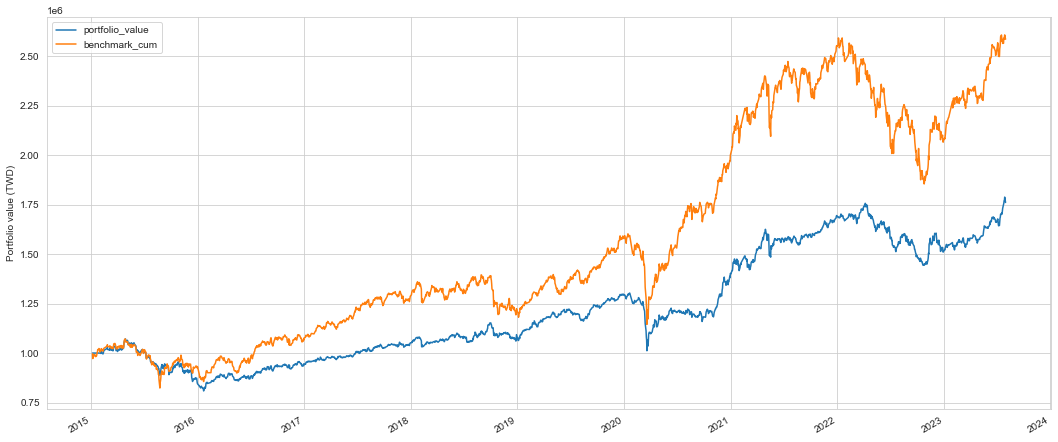

In [17]:
start_dt = pd.Timestamp('2015-01-01', tz='utc')
end_dt = pd.Timestamp('2023-07-31', tz='utc')

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return,
                                          )

Bindex=get_Benchmark_Return(start=start_dt,
                     end=end_dt,
                     symbol='IR0001').sort_index(ascending=True).tz_convert('utc')

results = run_algorithm(start=start_dt,  
                       end=end_dt,
                       initialize=initialize1,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       benchmark_returns=Bindex,
                       data_frequency='daily',
                       bundle='tquant',
                       custom_loader=transform_data,
                       analyze=portfolio_plot) 

### Pyfolio－投組績效分析

In [18]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline, print_table
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
results.benchmark_return.index = results.benchmark_return.index.tz_localize(None).tz_localize('UTC')

from pyfolio.plotting import show_perf_stats
show_perf_stats(returns=returns,
                factor_returns=results.benchmark_return,
                positions=positions,
                transactions=transactions,
                live_start_date='2022-01-01',
                )

,In-sample,Out-of-sample,All
Annual return,8.066%,2.62%,7.056%
Cumulative returns,69.383%,3.977%,76.12%
Annual volatility,10.829%,10.708%,10.806%
Sharpe ratio,0.77065,0.29492,0.685136
Calmar ratio,0.328531,0.147048,0.287384
Stability,0.814204,0.070648,0.876851
Max drawdown,-24.552%,-17.819%,-24.552%
Omega ratio,1.155028,1.049397,1.132991
Sortino ratio,1.072585,0.423856,0.958737
Skew,-0.474805,0.11805,-0.369928


Start date,2015-01-05
End date,2023-07-31
Total months,99
,Backtest
Annual return,7.056%
Cumulative returns,76.12%
Annual volatility,10.806%
Sharpe ratio,0.69
Calmar ratio,0.29
Stability,0.88
Max drawdown,-24.552%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.55,2015-04-28,2016-01-21,2018-01-16,673
1,22.40,2020-01-20,2020-03-19,2020-12-01,211
2,17.82,2022-04-06,2022-10-21,2023-07-25,319
3,8.66,2021-04-29,2021-05-17,2021-11-09,134
4,7.97,2018-10-01,2018-12-26,2019-02-21,95


Stress Events,mean,min,max
Fall2015,-0.12%,-2.81%,2.37%
New Normal,0.03%,-5.00%,5.52%


Top 10 long positions of all time,max
sid,
2325,66.88%
4938,41.89%
1216,30.89%
4904,29.25%
3045,22.37%
5876,21.96%
2412,18.01%
2912,16.66%
2357,16.58%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2325,66.88%
4938,41.89%
1216,30.89%
4904,29.25%
3045,22.37%
5876,21.96%
2412,18.01%
2912,16.66%
2357,16.58%


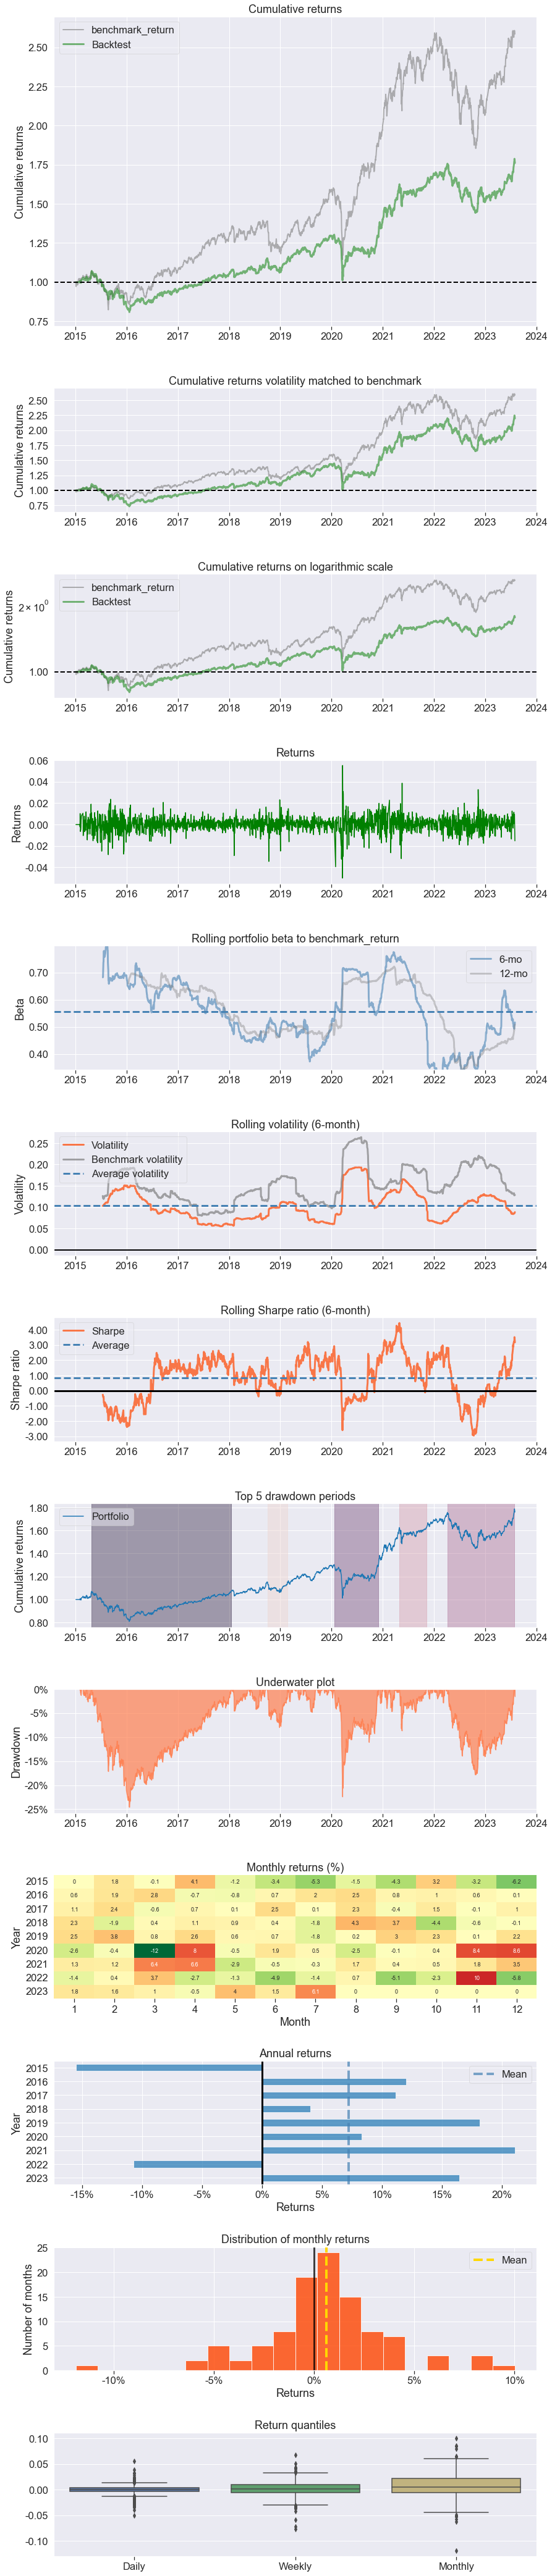

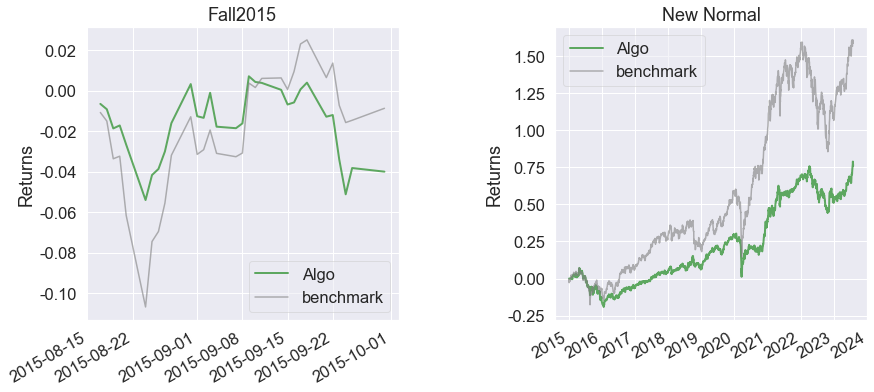

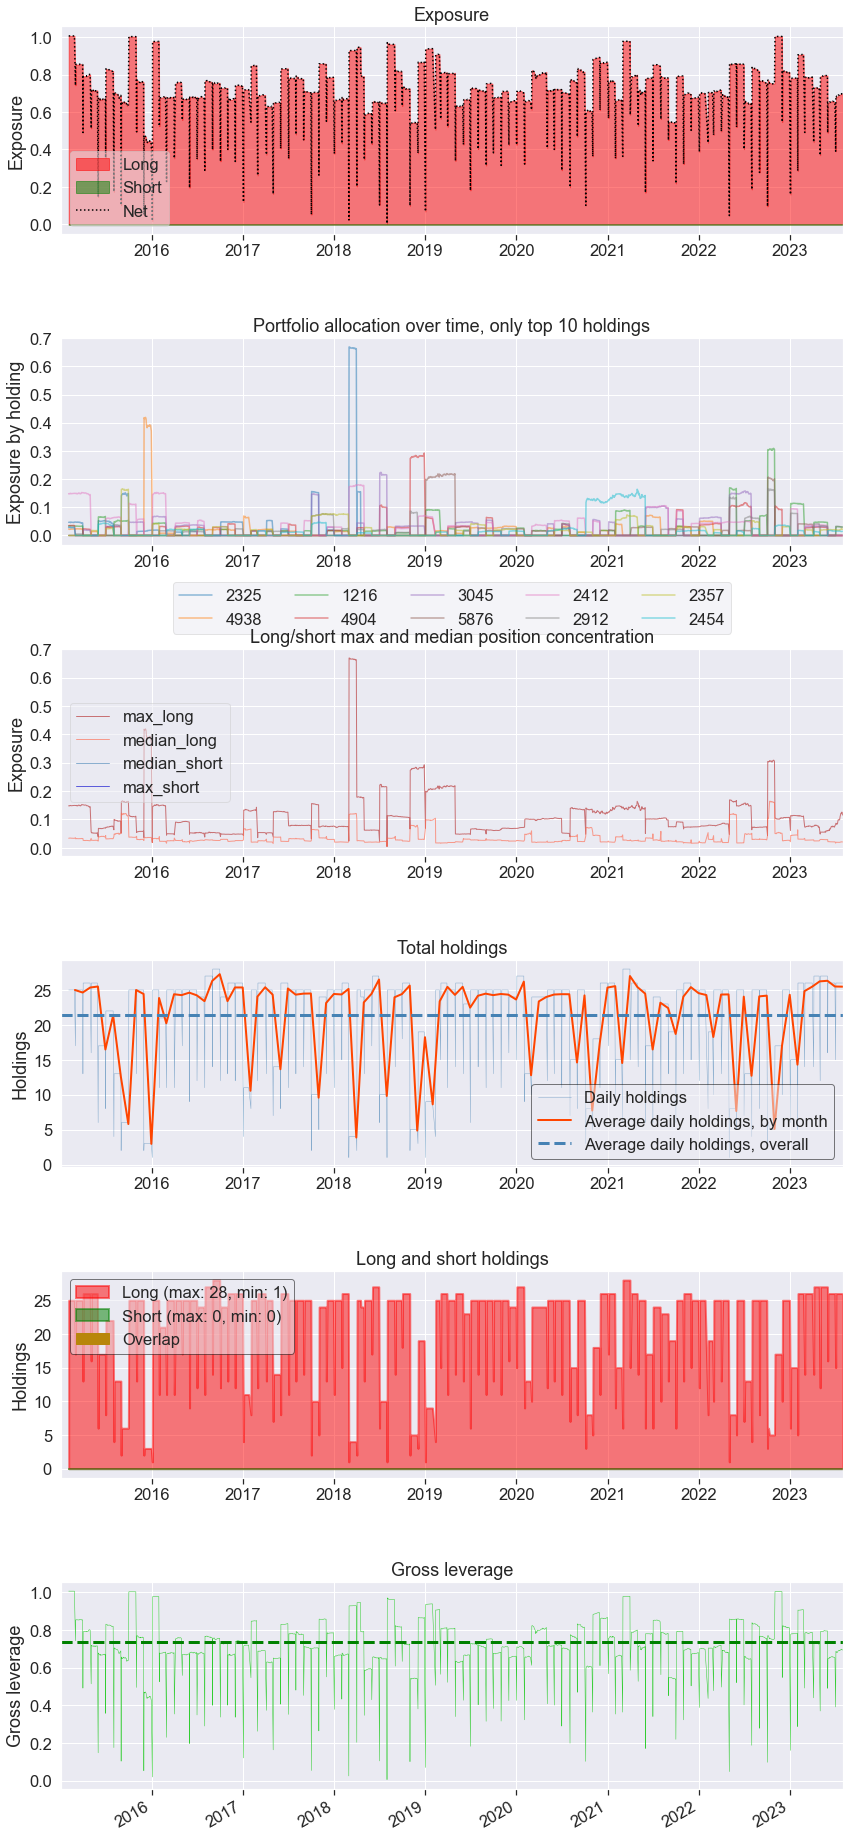

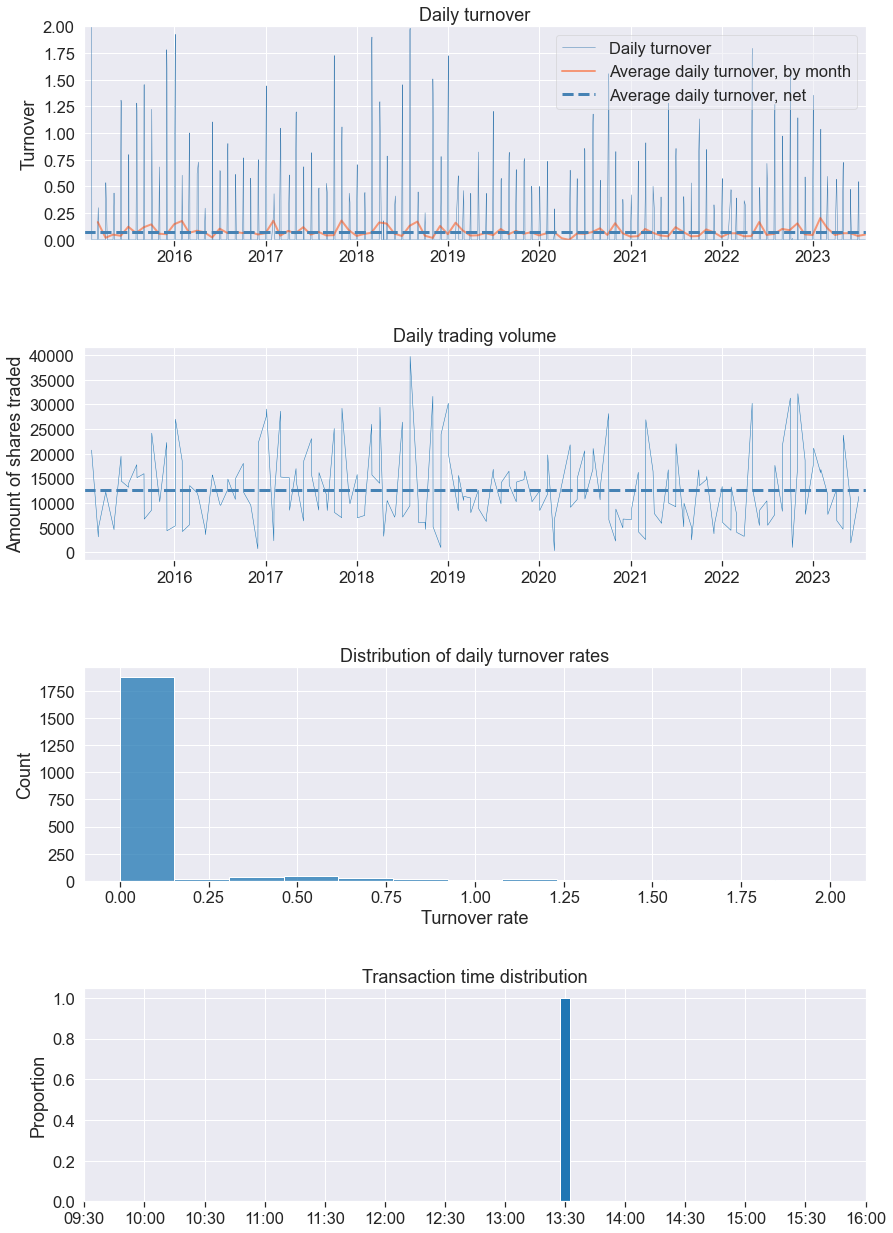

In [19]:
pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=results.benchmark_return)